In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import matplotlib.lines as mlines
import seaborn as sns
from keras.models import load_model
from sklearn.model_selection import KFold
from sklearn import preprocessing
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
import shap
from scipy.stats import pearsonr
import sys
sys.path.insert(0, '/Users/huripari/Documents/PhD/TCs_Genesis/tcg_fsM')
import utils_results as ut

In [ ]:
basin = 'NA'
perc = 80 
cluster_data_info = {'GLB': 'nc12', 'NEP': 'DSnc12', 'NWP': 'Anc10', 'NA': 'DSnc6', 'NI': 'DSnc12', 'SI':'DSnc9', 'SP': 'nc7'}
cluster_data = cluster_data_info[basin]
run_name = f'selfeat{perc}_top20_{cluster_data}_nv8_nd9'
years = np.arange(1980, 2022, 1) # from 1980 to 2021 included
n_folds = 3
n_clusters = int(run_name.split('nc')[1].split('_')[0])
nc_string = run_name.split('_')[2]
project_dir = '/Users/huripari/Documents/PhD/TCs_Genesis'
fs_dir = os.path.join(project_dir, 'tcg_fsM')

In [3]:
# Get the run info and data
run_info = ut.runs_info(basin, run_name)
dataset_opt = run_info[0]
dataset_opt_noFS = run_info[1]
Y_pred = run_info[2]
Y_pred_noFS = run_info[3]
Y_test = run_info[4]
X_test_eval = run_info[5]
X_test_eval_noFS = run_info[6]
mlps = run_info[7]
mlps_noFS = run_info[8]
perm_importance_mlp = run_info[9]
perm_importance_mlp_noFS = run_info[10]
shap_values_mlp = run_info[11]
shap_values_mlp_noFS = run_info[12]
X_test = pd.concat(X_test_eval)
X_test_noFS = pd.concat(X_test_eval_noFS)

2025-03-17 15:02:46.118012: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2025-03-17 15:02:46.118043: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2025-03-17 15:02:46.118047: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2025-03-17 15:02:46.118075: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-17 15:02:46.118092: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-03-17 15:02:46.379696: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


In [4]:
# Load the seasonality if working with deseason data
if "DS" in nc_string:
    cluster_data = f'{basin}_{n_clusters}clusters_deseason'
    data_dir = os.path.join(fs_dir, 'data', cluster_data)
    target_season = 'target_seasonality_1970-2022_2.5x2.5.csv'
    target_season_df = pd.read_csv(os.path.join(data_dir, target_season), index_col=0)
    target_season_df.index = pd.to_datetime(target_season_df.index)

**Time series Trajectories** 

In [5]:
# Concat the predictions and the test values
Y_pred_df = pd.concat(Y_pred)
Y_test_df = pd.concat(Y_test)
Y_pred_noFS_df = pd.concat(Y_pred_noFS)
if "DS" in nc_string:
    Y_pred_df['tcg'] = Y_pred_df['tcg'] + target_season_df.loc[Y_pred_df.index, 'seasonal']
    Y_test_df = Y_test_df + target_season_df.loc[Y_test_df.index, 'seasonal']
    Y_pred_noFS_df['tcg'] = Y_pred_noFS_df['tcg'] + target_season_df.loc[Y_pred_noFS_df.index, 'seasonal']
# values smaller than 0 are set to 0
Y_pred_df.loc[Y_pred_df['tcg'] < 0, 'tcg'] = 0.0
Y_pred_noFS_df.loc[Y_pred_noFS_df['tcg'] < 0, 'tcg'] = 0.0
# Compute seasonal mean values
Y_pred_df_season = Y_pred_df.groupby(Y_pred_df.index.month).mean()
Y_test_df_season = Y_test_df.groupby(Y_test_df.index.month).mean()
Y_pred_noFS_df_season = Y_pred_noFS_df.groupby(Y_pred_noFS_df.index.month).mean()
# Compute annual cumulative values
Y_pred_df_annual = Y_pred_df.groupby(Y_pred_df.index.year).sum()
Y_test_df_annual = Y_test_df.groupby(Y_test_df.index.year).sum()
Y_pred_noFS_df_annual = Y_pred_noFS_df.groupby(Y_pred_noFS_df.index.year).sum()
# Compute the correlation coefficient and the MSE between the predictions and the test values
# Monthly
r, _ = pearsonr(Y_test_df, Y_pred_df['tcg'])
mse = mean_squared_error(Y_test_df, Y_pred_df['tcg'])
r_noFS, _ = pearsonr(Y_test_df, Y_pred_noFS_df['tcg'])
mse_noFS = mean_squared_error(Y_test_df, Y_pred_noFS_df['tcg'])
print('========== Monthly =========')
print(f'FS  -  r: {r:.3f}, mse: {mse:.3f}')
print(f'NoFS - r: {r_noFS:.3f}, mse: {mse_noFS:.3f}')
# Seasonal
rS, _ = pearsonr(Y_test_df_season, Y_pred_df_season['tcg'])
mseS = mean_squared_error(Y_test_df_season, Y_pred_df_season['tcg'])
rS_noFS, _ = pearsonr(Y_test_df_season, Y_pred_noFS_df_season['tcg'])
mseS_noFS = mean_squared_error(Y_test_df_season, Y_pred_noFS_df_season['tcg'])
print('========== Seasonal ========')
print(f'FS  -  r: {rS:.3f}, mse: {mseS:.3f}')
print(f'NoFS - r: {rS_noFS:.3f}, mse: {mseS_noFS:.3f}')
# Annual
rY, _ = pearsonr(Y_test_df_annual, Y_pred_df_annual['tcg'])
mseY = mean_squared_error(Y_test_df_annual, Y_pred_df_annual['tcg'])
rY_noFS, _ = pearsonr(Y_test_df_annual, Y_pred_noFS_df_annual['tcg'])
mseY_noFS = mean_squared_error(Y_test_df_annual, Y_pred_noFS_df_annual['tcg'])
print('========== Annual ==========')
print(f'FS  -  r: {rY:.3f}, mse: {mseY:.3f}')
print(f'NoFS - r: {rY_noFS:.3f}, mse: {mseY_noFS:.3f}')


========== Monthly =========
FS  -  r: 0.811, mse: 1.156
NoFS - r: 0.810, mse: 1.124
========== Seasonal ========
FS  -  r: 0.998, mse: 0.040
NoFS - r: 0.999, mse: 0.004
========== Annual ==========
FS  -  r: 0.671, mse: 22.459
NoFS - r: 0.601, mse: 19.963


In [6]:
# Load time series of gpis
gpis_path = os.path.join(fs_dir, 'data', f'{basin}_2.5x2.5_gpis_time_series.csv')
gpis_df = pd.read_csv(gpis_path, index_col=0)
gpis_df.index = pd.to_datetime(gpis_df.index)
gpis_df = gpis_df.loc[Y_pred_df.index]
engpi = gpis_df['engpi']
ogpi = gpis_df['ogpi']
# Compute annual cumulative values and correlation coefficient
engpi_annual = engpi.groupby(engpi.index.year).sum()
ogpi_annual = ogpi.groupby(ogpi.index.year).sum()
rY_engpi, _ = pearsonr(Y_test_df_annual, engpi_annual)
rY_ogpi, _ = pearsonr(Y_test_df_annual, ogpi_annual)

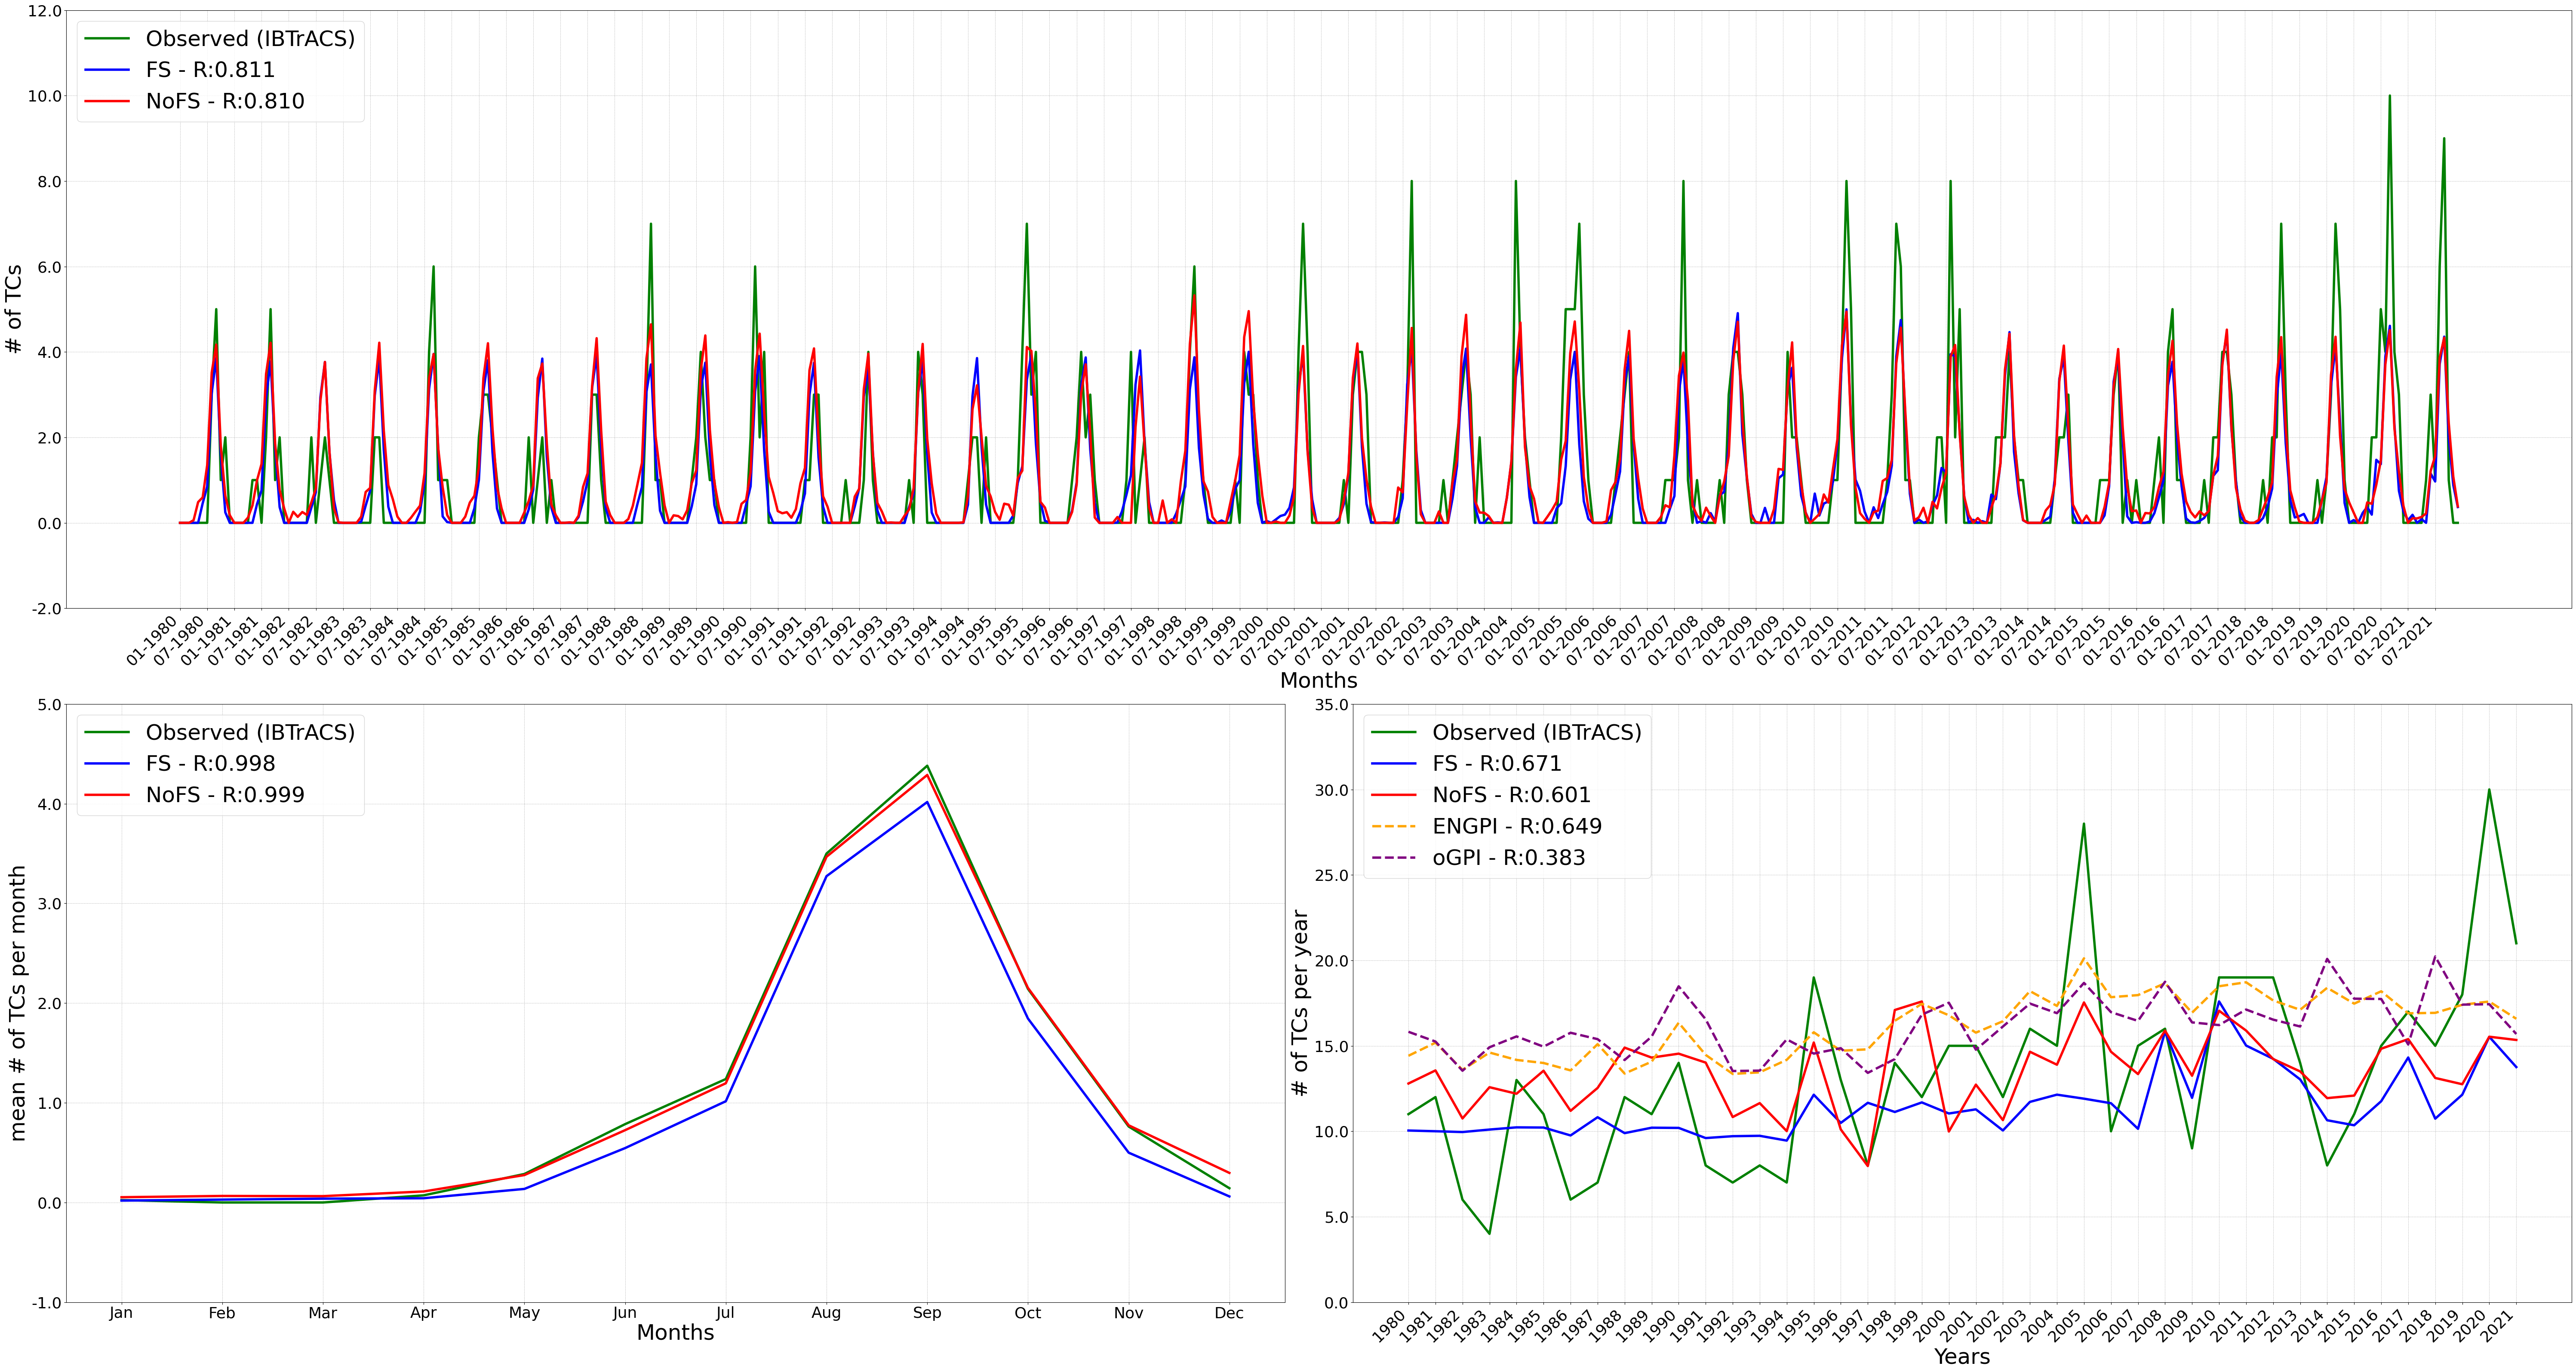

In [7]:
# Plot Time Series 
fig_ts = plt.figure(figsize=(60, 32))
gs = gridspec.GridSpec(2, 2, figure=fig_ts)
## Monthly time series ##
ax = fig_ts.add_subplot(gs[0, :])
xticks = pd.Series(Y_test_df.index).dt.strftime('%m-%Y').to_numpy()
# observations
ax.plot(xticks, Y_test_df, label='Observed (IBTrACS)', color='green', linewidth=4)
# predictions
ax.plot(xticks, Y_pred_df['tcg'], label=f'FS - R:{r:.3f}', color='blue', linewidth=4)
ax.plot(xticks, Y_pred_noFS_df['tcg'], label=f'NoFS - R:{r_noFS:.3f}', color='red', linewidth=4)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.set_xticks(ticks=np.arange(len(xticks))[::6])
ax.set_xticklabels(xticks[::6], rotation=45, fontsize=26, ha='right')
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels(ax.get_yticks(), fontsize=26)
ax.set_xlabel('Months', fontsize=36)
ax.set_ylabel('# of TCs', fontsize=36)
ax.legend(fontsize=36, loc='upper left')
## Seasonal time series ##
axS = fig_ts.add_subplot(gs[1, 0])
# observations
axS.plot(Y_test_df_season.index, Y_test_df_season, label='Observed (IBTrACS)', color='green', linewidth=4)
# mlp predictions
axS.plot(Y_pred_df_season.index, Y_pred_df_season['tcg'], label=f'FS - R:{rS:.3f}', color='blue', linewidth=4)
axS.plot(Y_pred_noFS_df_season.index, Y_pred_noFS_df_season['tcg'], label=f'NoFS - R:{rS_noFS:.3f}', color='red', linewidth=4)
axS.grid(True, which='both', linestyle='--', linewidth=0.5)
axS.set_xticks(Y_test_df_season.index)
axS.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=26)
axS.set_yticks(axS.get_yticks())
axS.set_yticklabels(axS.get_yticks(), fontsize=26)
axS.set_xlabel('Months', fontsize=36)
axS.set_ylabel('mean # of TCs per month', fontsize=36)
axS.legend(fontsize=36, loc='upper left')
## Annual time series ##
axY = fig_ts.add_subplot(gs[1, 1])
# observations
axY.plot(Y_test_df_annual.index, Y_test_df_annual, label='Observed (IBTrACS)', color='green', linewidth=4)
# mlp predictions
axY.plot(Y_pred_df_annual.index, Y_pred_df_annual['tcg'], label=f'FS - R:{rY:.3f}', color='blue', linewidth=4)
axY.plot(Y_pred_noFS_df_annual.index, Y_pred_noFS_df_annual['tcg'], label=f'NoFS - R:{rY_noFS:.3f}', color='red', linewidth=4)
# gpis
axY.plot(engpi_annual.index, engpi_annual, label=f'ENGPI - R:{rY_engpi:.3f}', color='orange', linewidth=4, linestyle='--')
axY.plot(ogpi_annual.index, ogpi_annual, label=f'oGPI - R:{rY_ogpi:.3f}', color='purple', linewidth=4, linestyle='--')
axY.grid(True, which='both', linestyle='--', linewidth=0.5)
axY.set_xticks(Y_test_df_annual.index)
axY.set_xticklabels(Y_test_df_annual.index, rotation=45, fontsize=26, ha='right')
axY.set_yticks(axY.get_yticks())
axY.set_yticklabels(axY.get_yticks(), fontsize=26)
axY.set_xlabel('Years', fontsize=36)
axY.set_ylabel('# of TCs per year', fontsize=36)
axY.legend(fontsize=36, loc='upper left')

fig_ts.set_tight_layout(True)
plt.show()

**Permutation Importance**

Permutation feature importance is a model inspection technique that measures the contribution of each feature to a fitted model’s statistical performance on a given tabular dataset. This technique is particularly useful for non-linear or opaque estimators, and involves randomly shuffling the values of a single feature and observing the resulting degradation of the model’s score. By breaking the relationship between the feature and the target, we determine how much the model relies on such particular feature.

The estimator is required to be a fitted estimator. X can be the data set used to train the estimator or a hold-out set. The permutation importance of a feature is calculated as follows. First, a baseline metric, defined by scoring, is evaluated on a (potentially different) dataset defined by the X. Next, a feature column from the validation set is permuted and the metric is evaluated again. The permutation importance is defined to be the difference between the baseline metric and metric from permutating the feature column.

In [8]:
# Mean importance of the features by fold models
# colors = ['red', 'blue', 'green']
# plt.figure(figsize=(X_test.shape[1]/2, 5))
# bar_width = 0.25 

# kfold = KFold(n_splits=n_folds)
# for nf, (train_index, test_index) in enumerate(kfold.split(years)):
#     test_years = years[test_index]
#     xt = X_test_eval[nf]
#     feature_importance = perm_importance_mlp[nf]["importances_mean"]
#     bar_positions = np.arange(xt.shape[1]) + nf * bar_width  # offset each bar
#     plt.bar(bar_positions, feature_importance, width=bar_width, align="center", color=colors[nf], label=f'Fold {nf+1} - [{test_years[0]}-{test_years[-1]}]')

# x_labels = ['{}'.format(col.split('_l')[0]) for col in np.array(xt.columns)]
# plt.xticks(np.arange(xt.shape[1]) + bar_width, x_labels, rotation=45, ha='right')

# plt.xlabel("Features")
# plt.ylabel("Mean Importance")
# plt.legend()
# plt.xlim([-1 * bar_width, xt.shape[1]])
# plt.tight_layout()
# plt.show()

In [9]:
# Mean of mean importance of the features
# mean_perm_importance = np.mean(np.array([perm_importance_mlp[nf]["importances_mean"] for nf in range(n_folds)]), axis=0)
# plt.figure(figsize=(xt.shape[1]/2, 5))
# bar_positions = np.arange(xt.shape[1]) + bar_width
# plt.bar(bar_positions, mean_perm_importance, align="center", label='Mean Importance')
# x_labels = ['{}'.format(col.split('_l')[0]) for col in np.array(xt.columns)]
# plt.xticks(np.arange(xt.shape[1]) + bar_width, x_labels, rotation=45, ha='right')
# plt.xlabel("Features")
# plt.ylabel("Mean Importance")
# plt.tight_layout()
# plt.show()

In [10]:
# colors = ['red', 'blue', 'green']
# plt.figure(figsize=(X_test_noFS.shape[1]/2, 8))
# bar_width = 0.25 

# for nf, (train_index, test_index) in enumerate(kfold.split(years)):
#     test_years = years[test_index]
#     feature_importance = perm_importance_mlp_noFS[nf]["importances_mean"]
#     bar_positions = np.arange(X_test_noFS.shape[1]) + nf * bar_width  # offset each bar
#     plt.bar(bar_positions, feature_importance, width=bar_width, align="center", color=colors[nf], label=f'Fold {nf+1} - [{test_years[0]}-{test_years[-1]}]')

# x_labels = ['{}'.format(col.split('_l')[0]) for col in np.array(X_test_noFS.columns)]
# plt.xticks(np.arange(X_test_noFS.shape[1]) + bar_width, x_labels, rotation=45, ha='right')

# plt.xlabel("Features")
# plt.ylabel("Mean Importance")
# plt.legend()
# plt.xlim([-1 * bar_width, X_test_noFS.shape[1]])
# plt.tight_layout()
# plt.show()

**SHAP values**

SHAP values measure how much each feature (such as income, age, credit score, etc.) contributes to the model's prediction. 
SHAP (SHapley Additive exPlanations) values are a way to explain the output of any machine learning model. It uses a game theoretic approach that measures each player's contribution to the final outcome. In machine learning, each feature is assigned an importance value representing its contribution to the model's output. SHAP values show how each feature affects each final prediction, the significance of each feature compared to others, and the model's reliance on the interaction between features. 
Features with positive SHAP values positively impact the prediction, while those with negative values have a negative impact. The magnitude is a measure of how strong the effect is.

Properties of SHAP values:
1. Additivity
2. Local accuracy
3. Missingness
4. Consistency

At its core, SHAP values aim to assign a numerical value to each feature, showcasing how much that particular feature influenced the model’s prediction for a specific data point. By considering all possible combinations of features and their contributions, SHAP values offer a comprehensive understanding of feature importance within the model.

/opt/miniconda3/envs/weather/lib/python3.11/site-packages/shap/plots/_beeswarm.py:950: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  pl.tight_layout()
/opt/miniconda3/envs/weather/lib/python3.11/site-packages/shap/plots/_beeswarm.py:950: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  pl.tight_layout()


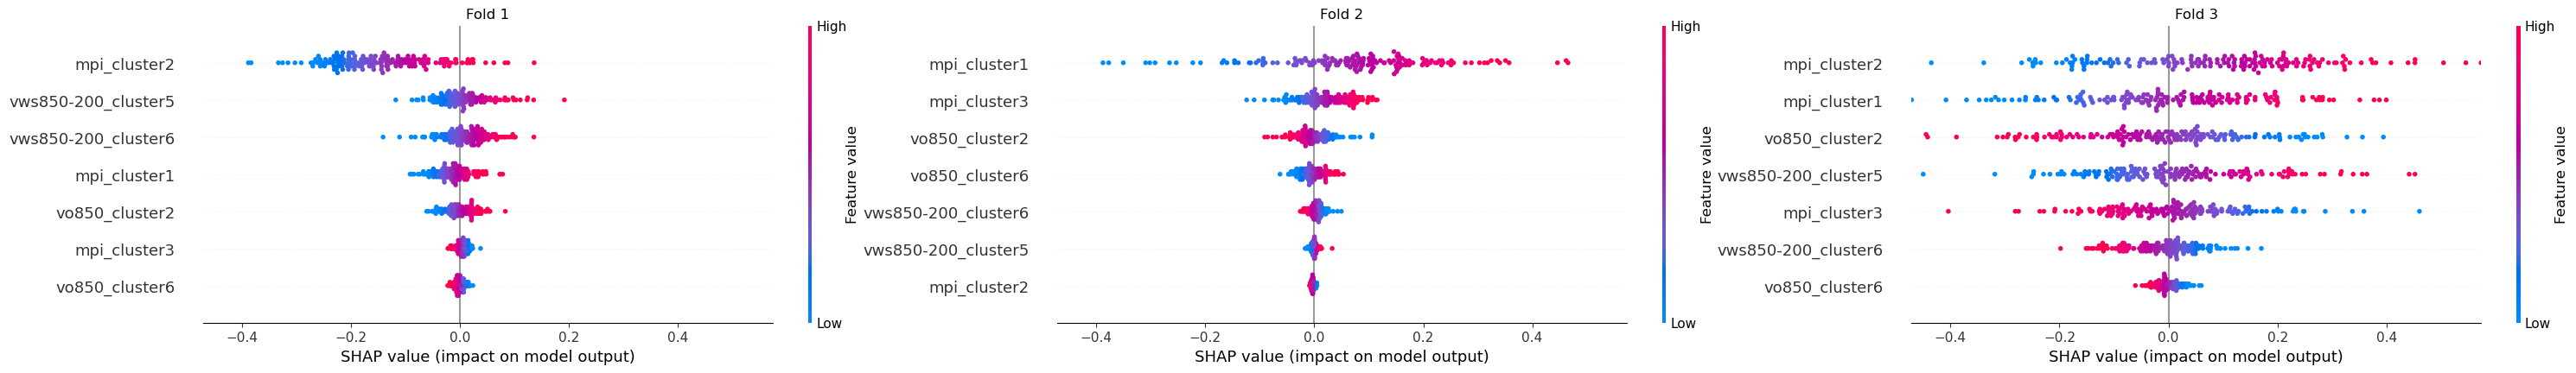

In [11]:
# get min and max values for the x-axis
xmin = min([shap.values.min() for shap in shap_values_mlp])
xmax = max([shap.values.max() for shap in shap_values_mlp])
# get min and max values for the colorbar
vmin = min([shap.data.min() for shap in shap_values_mlp])
vmax = max([shap.data.max() for shap in shap_values_mlp])

fig, axes = plt.subplots(1, 3, figsize=(20, 10))

for nf in range(3):
    plt.sca(axes[nf])
    shap.summary_plot(shap_values_mlp[nf], max_display=25, show=False)
    plt.xlim(xmin, xmax)
    sm = plt.cm.ScalarMappable(cmap="coolwarm")
    sm.set_clim(vmin, vmax)
    axes[nf].set_title(f'Fold {nf+1}') 

plt.subplots_adjust(left=0, right=3.5, wspace=0.2, bottom=0.1, top=0.9)
plt.show()

The beeswarm plot, often used in the context of SHAP values, provides a visual summary of feature importance across multiple instances or predictions. Observing a beeswarm plot can yield several insights:
1. _Feature Importance Spread_: The spread of points along the x-axis for each feature indicates the range and distribution of SHAP values across different instances. A wider spread signifies varying importance levels of that feature across the dataset.
2. _Relative Impact_: The horizontal position of the points for a feature showcases the magnitude of its impact on predictions. Features with points shifted to the right (higher SHAP values) indicate more substantial positive contributions, while those shifted to the left (lower SHAP values) represent negative contributions.
3. _Consistency of Feature Influence_: Consistent positions (clusters or consistent distributions) of points for a feature across different instances indicate its stable impact on predictions. Conversely, scattered or irregular distributions might imply fluctuating importance or varying effects.
4. _Comparative Importance_: Comparing the distribution and spread of points between different features allows you to assess their relative importance. Features with more spread-out or consistently shifted points might hold higher significance in the model’s predictions.
5. _Outliers and Anomalies_: Outlying points or clusters diverging from the main distribution for a feature might highlight specific instances where that feature has an unexpected or unique impact on predictions.
6. _Interactions between Features_: Beeswarm plots can reveal potential interactions or dependencies between features. If the distributions or positions of points change concerning specific combinations of features, it suggests potential interactions that influence predictions.
7. _Model Consistency_: Consistency in the distributions and positions of points across multiple models or model versions indicates robustness in feature importance assessments.

In [12]:
ordered_features = {
    'GLB': ['PDO', 'msl_cluster11', 'abs_vo850_cluster6', 'sst_cluster12', 'vws850-200_cluster2', 'vo850_cluster8', 'month', 'abs_vo850_cluster5', 
            'mpi_cluster12', 'sst_cluster9']
}

In [13]:
basin_ordered_features = ordered_features[basin]
# Set the figure and the gridspec for the subplots -> horizontal layout
fig = plt.figure(figsize=(20, 12))
gs = gridspec.GridSpec(2, 4, figure=fig)
ax_pos = [0, 2, 5]
jitter_strength = 0.12

# Cycle over the shap values of the 3 folds
for nf, shape_values in enumerate(shap_values_mlp):
    feat_names = np.array(shape_values.feature_names)
    # Set the colorbar for the subplots
    data_values = shape_values.data
    vmin = data_values.min()
    vmax = data_values.max()
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    cmap = plt.get_cmap('bwr')
    # Create the subplot
    ax = fig.add_subplot(gs[ax_pos[nf]:ax_pos[nf]+2])
    # Plot the SHAP values
    for n_feat, feature in enumerate(basin_ordered_features):
        # Get the position of the feature in the SHAP values
        feat_pos = np.where(feature == feat_names)[0][0]
        # Get the data for the scatter plot
        x_data = shape_values.values[:, feat_pos]
        spread = np.random.normal(0, jitter_strength, size=x_data.shape)
        y_data = np.zeros_like(x_data) + n_feat + spread
        color_data = data_values[:, feat_pos]
        # Plot the scatter plot
        ax.scatter(x_data, y_data, c=color_data, cmap=cmap, norm=norm, s=16)
    # Add a colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, fraction=0.05, pad=0.01)
    cbar.ax.set_aspect(50) # adjust the aspect ratio to thin colorbar
    cbar.set_ticks([vmin, vmax]) # set the ticks
    cbar.set_ticklabels(['Low', 'High'], fontsize=16) # set the tick labels
    cbar.outline.set_visible(False) # remove the colorbar outline
    cbar.set_label('Feature Value', labelpad=-30, fontsize=16)
    # Set yticks
    ax.set_yticks(np.arange(len(basin_ordered_features)))
    ax.set_yticklabels(basin_ordered_features, fontdict={'fontsize': 16})
    # Set xticks
    ax.set_xticks(np.arange(-3, 3.1, 1))
    ax.set_xticklabels(np.arange(-3, 3.1, 1), fontdict={'fontsize': 14})
    ax.set_xlabel('SHAP values (impact on model output)', fontdict={'fontsize': 16})
    # Add a vertical line at 0
    ax.axvline(x=0, color='black', linestyle='--', zorder=0)
    # Add horizontal lines at each feature
    for n_feat in range(len(basin_ordered_features)):
        ax.axhline(y=n_feat, color='grey', linestyle=':', linewidth=0.5, zorder=0)
    # Set the title
    ax.set_title(f'Fold {nf+1}', fontsize=18)
    # Remove axis outline
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
# Adjust the layout
fig.set_tight_layout(True)
# Save the figure
file_path = os.path.join('figures', f'{basin}', f'shap_analysis_{basin}.pdf')
fig.savefig(file_path, format='pdf', bbox_inches='tight', dpi=300)
plt.show()

KeyError: 'NEP'

/opt/miniconda3/envs/weather/lib/python3.11/site-packages/shap/plots/_beeswarm.py:950: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  pl.tight_layout()
/opt/miniconda3/envs/weather/lib/python3.11/site-packages/shap/plots/_beeswarm.py:950: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  pl.tight_layout()


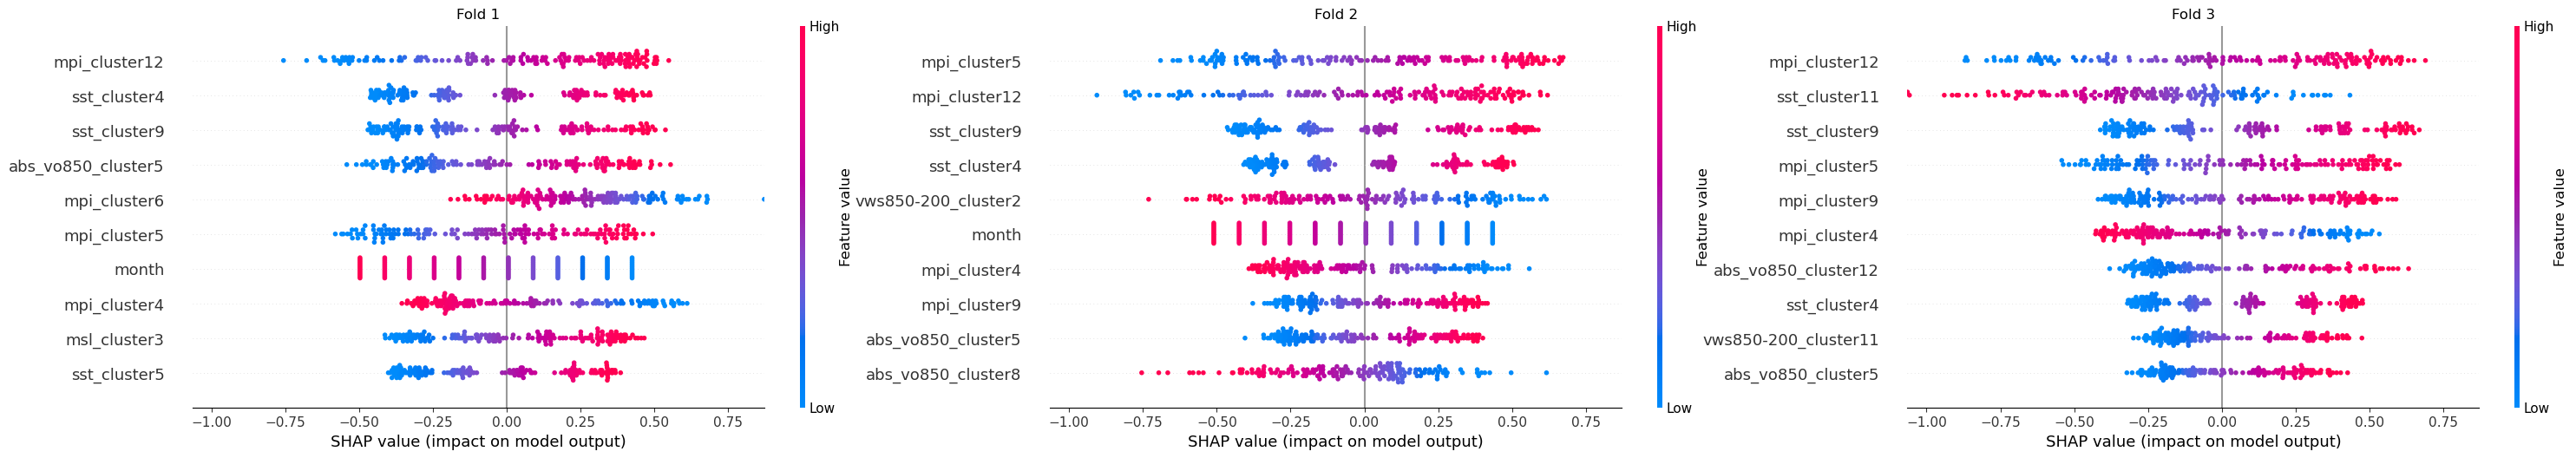

In [16]:
# get min and max values for the x-axis
xmin = min([shap.values.min() for shap in shap_values_mlp_noFS])
xmax = max([shap.values.max() for shap in shap_values_mlp_noFS])
# get min and max values for the colorbar
vmin = min([shap.data.min() for shap in shap_values_mlp_noFS])
vmax = max([shap.data.max() for shap in shap_values_mlp_noFS])

fig, axes = plt.subplots(1, 3, figsize=(20, 10))

for nf in range(3):
    plt.sca(axes[nf])
    shap.summary_plot(shap_values_mlp_noFS[nf], max_display=10, show=False)
    plt.xlim(xmin, xmax)
    sm = plt.cm.ScalarMappable(cmap="coolwarm")
    sm.set_clim(vmin, vmax)
    axes[nf].set_title(f'Fold {nf+1}') 

plt.subplots_adjust(left=0, right=3.5, wspace=0.2, bottom=0.1, top=0.9)
plt.show()

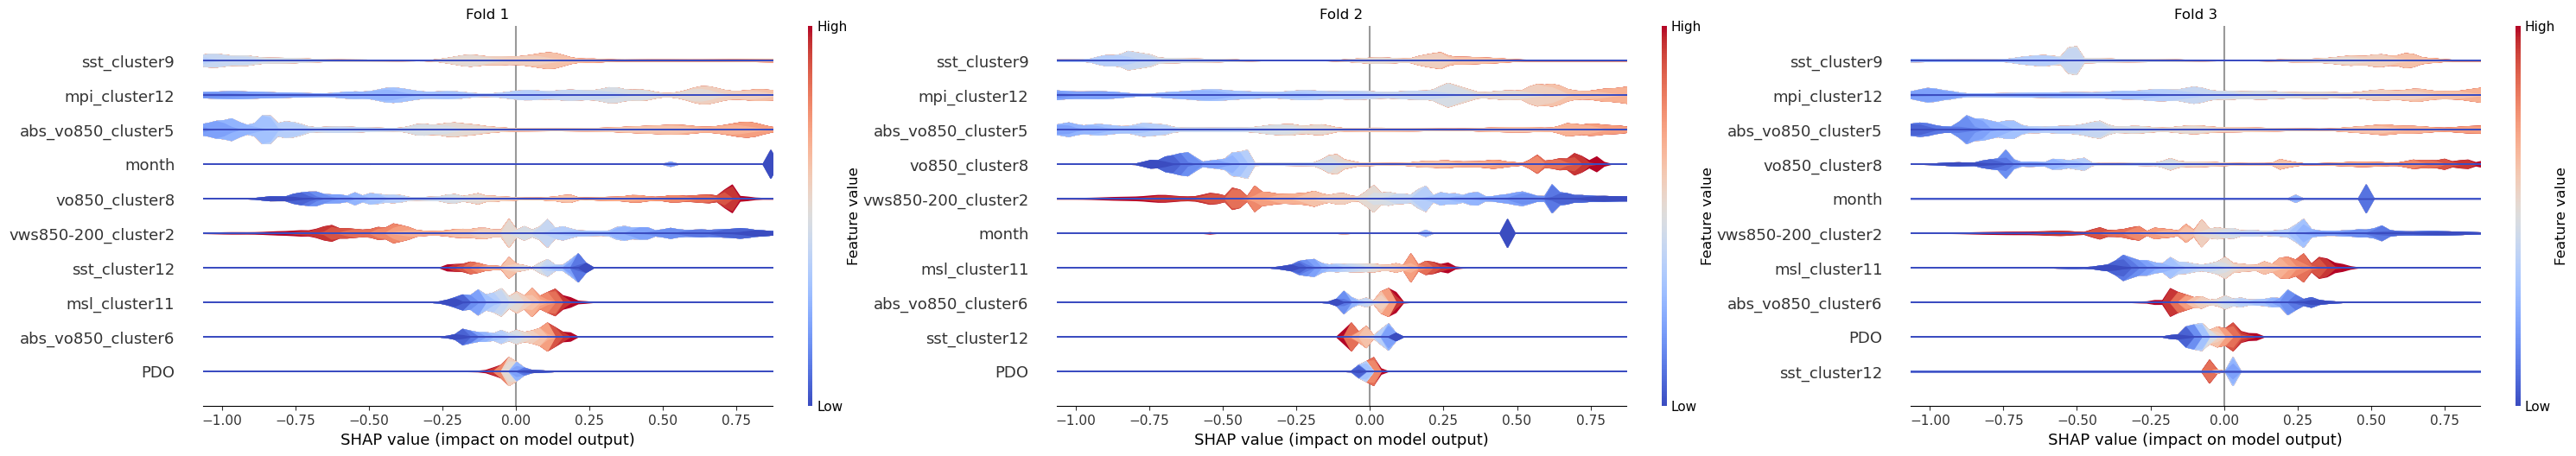

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(20, 10))

for nf in range(3):
    plt.sca(axes[nf])
    shap.plots.violin(shap_values_mlp[nf], plot_type="layered_violin", max_display=25, show=False)
    plt.xlim(xmin, xmax)
    sm = plt.cm.ScalarMappable(cmap="coolwarm")
    sm.set_clim(vmin, vmax)
    axes[nf].set_title(f'Fold {nf+1}') 

plt.subplots_adjust(left=0, right=3.5, wspace=0.2, bottom=0.1, top=0.9)
plt.show()

Violin plots use “violin-shaped” figures to display the distribution and density of SHAP values for their respective feature. The violins can therefore provide insights into the range, variability, skewness, symmetry, and multimodality of the SHAP value distribution for a specific feature.
The overall violin summary plot allow for comparisons in feature importance. Wider violins indicate higher density and more frequent values, thus providing insights into the relative importance of each feature with regard to the model output.

The layered violin summary plot is identical to the violin one, except that outliers are not drawn as scatter points and it provides insights on the impact on the output of feature values (high/low) in the data. We can now also get get a sense of the direction of the impact from the data. Red represents large values of a variable, and blue represents small ones, for the considered feature.

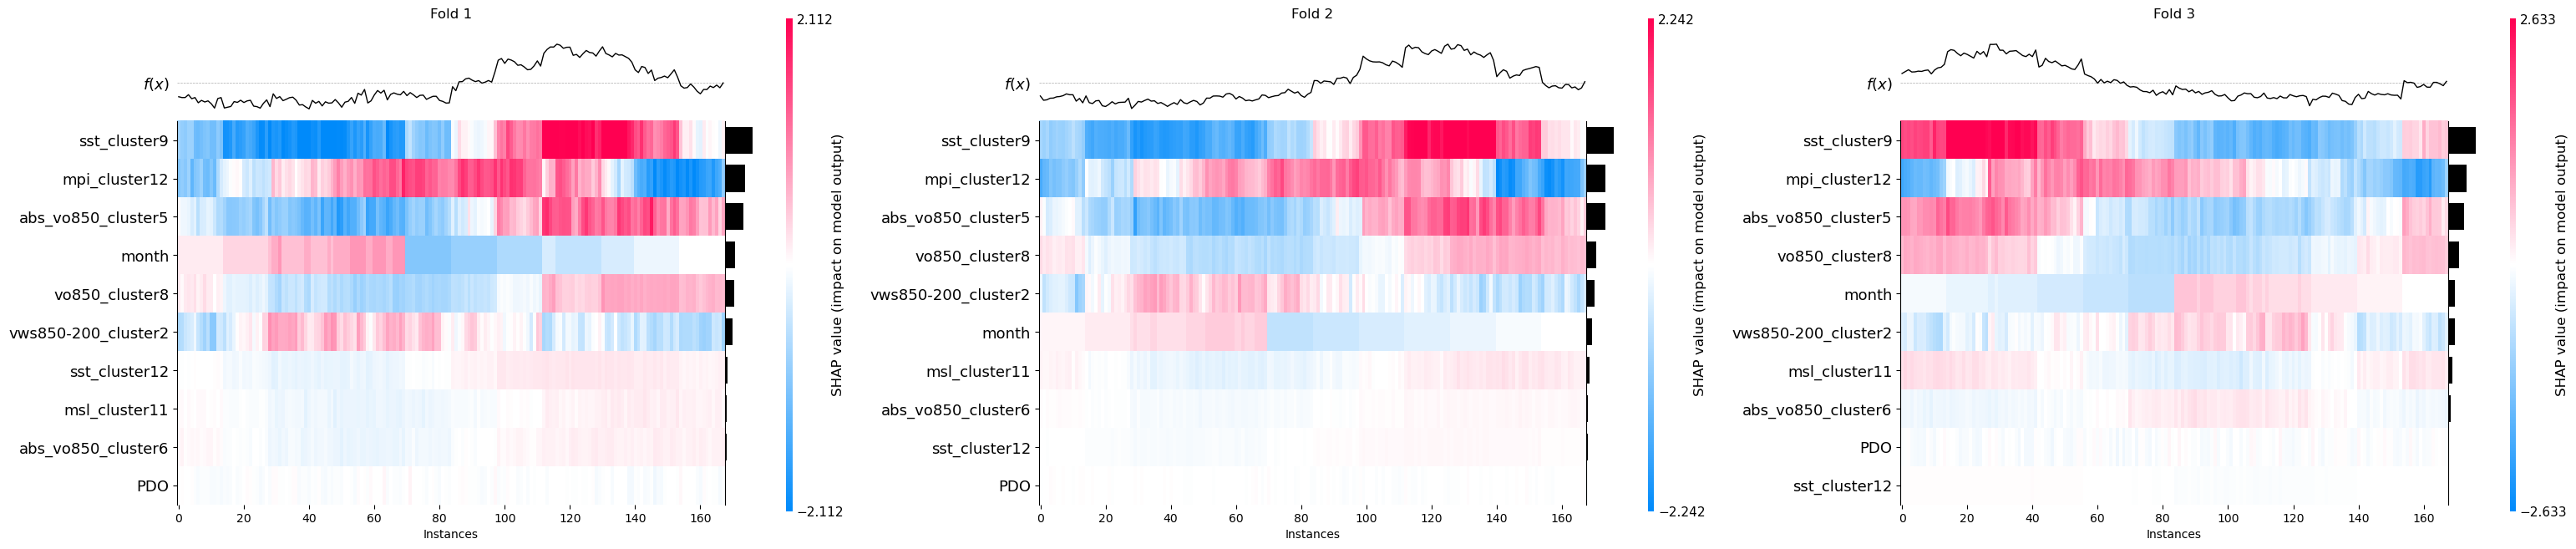

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(20, 10))

for nf in range(3):
    plt.sca(axes[nf])
    shap.plots.heatmap(shap_values_mlp[nf], max_display=25, show=False)
    axes[nf].set_title(f'Fold {nf+1}')

plt.subplots_adjust(left=0, right=3.5, wspace=0.4, bottom=0.1, top=0.9)
plt.show()

Passing a matrix of SHAP values to the heatmap plot function creates a plot with the instances on the x-axis, the model inputs on the y-axis, and the SHAP values encoded on a color scale. By default the samples are ordered using ```shap.order.hclust```, which orders the samples based on a hierarchical clustering by their explanation similarity. This results in samples that have the same model output for the same reason getting grouped together.

The output of the model is shown above the heatmap matrix (centered around the explaination’s ```.base_value```), and the global importance of each model input shown as a bar plot on the right hand side of the plot (by default this is the ```shap.order.abs.mean``` measure of overall importance).

In [19]:
# fig, axes = plt.subplots(1, 3, figsize=(20, 10))

# for nf in range(3):
#     plt.sca(axes[nf])
#     shap.plots.heatmap(shap_values_mlp[nf], instance_order=shap_values_mlp[nf].values.sum(1), max_display=20, show=False)
#     axes[nf].set_title(f'Fold {nf+1}') 

# plt.subplots_adjust(left=0, right=3.5, wspace=0.4, bottom=0.1, top=0.9)
# plt.show()

In [20]:
# Check waterfall plot for a specific prediction - prediction for max value
# fig, axes = plt.subplots(1, 3, figsize=(20, 10))

# for nf in range(3):
#     sample_idx = Y_pred[nf].index.get_loc(Y_pred[nf].tcg.idxmax())
#     plt.sca(axes[nf])
#     shap.plots.waterfall(shap_values_mlp[nf][sample_idx], max_display=20, show=False)
#     axes[nf].set_title(f'Fold {nf+1}') 

# plt.subplots_adjust(left=0, right=3.5, wspace=0.35, bottom=0.1, top=0.9)
# plt.show()


In [21]:
# Check waterfall plot for a specific prediction - prediction for min value
# fig, axes = plt.subplots(1, 3, figsize=(20, 10))

# for nf in range(3):
#     sample_idx = Y_pred[nf].index.get_loc(Y_pred[nf].tcg.idxmin())
#     plt.sca(axes[nf])
#     shap.plots.waterfall(shap_values_mlp[nf][sample_idx], max_display=20, show=False)
#     axes[nf].set_title(f'Fold {nf+1}') 

# plt.subplots_adjust(left=0, right=3.5, wspace=0.35, bottom=0.1, top=0.9)
# plt.show()

In [22]:
# shap.dependence_plot('sst_cluster6', shap_values_mlp[0].values, X_test_eval[0], interaction_index='mpi_cluster8')

In [154]:
# Dicionary containing the couples of years for each fold to used for more deepen analysis
years_couples = {
    'GLB': ([1990, 1987], [1994, 1998], [2015, 2010])
    }
ordered_features = {
    'GLB': ['PDO', 'msl_cluster11', 'abs_vo850_cluster6', 'sst_cluster12', 'vws850-200_cluster2', 'vo850_cluster8', 'month', 'abs_vo850_cluster5', 
            'mpi_cluster12', 'sst_cluster9']
}
# Create a DataFrame with fold number corresponding to each year
kfold = KFold(n_splits=n_folds)
test_years_df = pd.DataFrame(0, index=years, columns=['fold'])
for nf, (train_index, test_index) in enumerate(kfold.split(years)):
    test_years_df.loc[years[test_index], 'fold'] = nf

In [223]:
# basin_years_couple = years_couples[basin]
# basin_ordered_features = ordered_features[basin]

# orientation = 'horizontal'

# if orientation == 'vertical':
#     # Set the figure and the gridspec for the subplots -> vertical layout
#     fig = plt.figure(figsize=(8, 14))
#     gs = gridspec.GridSpec(3, 1, figure=fig)
#     ax_pos = [0, 1, 2]
# elif orientation == 'horizontal':
#     # Set the figure and the gridspec for the subplots -> horizontal layout
#     fig = plt.figure(figsize=(14, 8))
#     gs = gridspec.GridSpec(2, 4, figure=fig)
#     ax_pos = [0, 2, 5]

# for yb, years_for_analysis in enumerate(basin_years_couple):
#     # Indentify the fold of the years considered
#     fold = test_years_df.loc[years_for_analysis[0], 'fold']
#     shap_values_fold = shap_values_mlp[fold]
#     Y_test_fold = Y_test[fold]
#     # Set the colorbar for this subplot
#     shap_years = []
#     for yy, year in enumerate(years_for_analysis):
#         indices = Y_test_fold.index.year == year
#         shap_year = shap_values_fold[indices]
#         shap_years.append(shap_year)
#     data_values = np.array([shap_year.data for shap_year in shap_years])
#     vmin = data_values.min()
#     vmax = data_values.max()
#     norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
#     cmap = plt.get_cmap('bwr')
#     # Create the subplot
#     ax = fig.add_subplot(gs[ax_pos[yb]]) if orientation == 'vertical' else fig.add_subplot(gs[ax_pos[yb]:ax_pos[yb]+2])
#     # List for legend handles
#     legend_handles = []
#     # Loop over the two years to plot the SHAP values
#     for yy, shap_year in enumerate(shap_years):
#         year = years_for_analysis[yy]
#         # Get the feature names and the data values
#         feat_names = np.array(shap_year.feature_names)
#         data_values = shap_year.data
#         # Set a positions, markers and labels for the scatter plot
#         yy_pos = 0.15 if yy == 0 else -0.15
#         shape = 'D' if yy == 0 else 'o'
#         year_kind = 'max' if yy == 0 else 'min'
#         # Make the scatter plot cycling over the predefined ordered features
#         for n_feat, feature in enumerate(basin_ordered_features):
#             # Get the position of the feature in the SHAP values
#             feat_pos = np.where(feature == feat_names)[0][0]
#             # Get the data for the scatter plot
#             x_data = shap_year.values[:, feat_pos]
#             y_data = np.zeros_like(x_data) + n_feat + yy_pos
#             color_data = data_values[:, feat_pos]
#             # Plot the scatter plot
#             ax.scatter(x_data, y_data, c=color_data, marker=shape, cmap=cmap, norm=norm)
#         # Add a legend handle for the year
#         legend_handle = mlines.Line2D([], [], color='grey', marker=shape, linestyle='None', markersize=8, label=f'{year} ({year_kind})')
#         legend_handles.append(legend_handle)
#     # Add legend 
#     ax.legend(handles=legend_handles, loc='center right')
#     # Add colorbar
#     sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
#     sm.set_array([])
#     cbar = plt.colorbar(sm, ax=ax, fraction=0.03, pad=0.01)
#     cbar.ax.set_aspect(50) # adjust the aspect ratio to thin colorbar
#     cbar.set_ticks([vmin, vmax]) # set the ticks
#     cbar.set_ticklabels(['Low', 'High'], fontsize=10) # set the tick labels
#     cbar.outline.set_visible(False) # remove the colorbar outline
#     cbar.set_label('Feature Value', labelpad=-15)
#     # Set yticks
#     ax.set_yticks(np.arange(len(basin_ordered_features)))
#     ax.set_yticklabels(basin_ordered_features)
#     # Set xticks
#     ax.set_xticks(np.arange(-3, 3.1, 0.5))
#     ax.set_xticklabels(np.arange(-3, 3.1, 0.5))
#     ax.set_xlabel('SHAP values')
#     # Add a vertical line at 0
#     ax.axvline(x=0, color='black', linestyle='--')
#     # Add horizontal lines at each feature
#     for n_feat in range(len(basin_ordered_features)):
#         ax.axhline(y=n_feat, color='grey', linestyle=':', linewidth=0.5)
#     # Set the title
#     ax.set_title(f'Fold {fold+1}')
# # Adjust the layout
# fig.set_tight_layout(True)

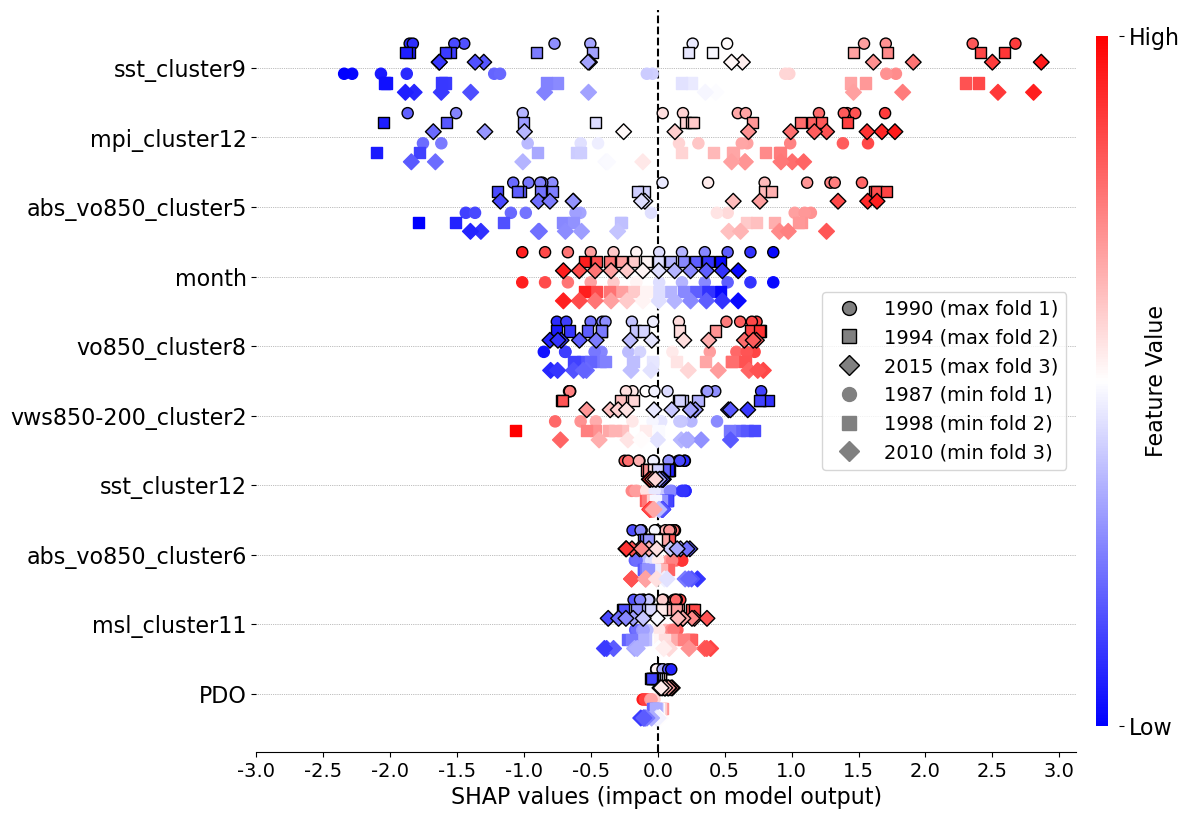

In [ ]:
basin_years_couple = years_couples[basin]
basin_ordered_features = ordered_features[basin]

# Set the figure and the gridspec for the subplots -> vertical layout
fig = plt.figure(figsize=(12, 24))
gs = gridspec.GridSpec(3, 1, figure=fig)
ax = fig.add_subplot(gs[0])
vmins = []
vmaxs = []
for yb, years_for_analysis in enumerate(basin_years_couple):
    # Indentify the fold of the years considered
    fold = test_years_df.loc[years_for_analysis[0], 'fold']
    shap_values_fold = shap_values_mlp[fold]
    Y_test_fold = Y_test[fold]
    # Set the colorbar for this subplot
    shap_years = []
    for yy, year in enumerate(years_for_analysis):
        indices = Y_test_fold.index.year == year
        shap_year = shap_values_fold[indices]
        shap_years.append(shap_year)
    data_values = np.array([shap_year.data for shap_year in shap_years])
    vmin = data_values.min()
    vmax = data_values.max()
    vmins.append(vmin)
    vmaxs.append(vmax)
vmin = min(vmins)
vmax = max(vmaxs)
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
cmap = plt.get_cmap('bwr')
# List for legend handles
legend_handles = []
# Set the different markers 
markers = ['o', 's', 'D']
for yb, years_for_analysis in enumerate(basin_years_couple):
    # Indentify the fold of the years considered
    fold = test_years_df.loc[years_for_analysis[0], 'fold']
    shap_values_fold = shap_values_mlp[fold]
    Y_test_fold = Y_test[fold]
    # Loop over the two years to plot the SHAP values
    for yy, year in enumerate(years_for_analysis):
        indices = Y_test_fold.index.year == year
        shap_year = shap_values_fold[indices]
        # Get the feature names and the data values
        feat_names = np.array(shap_year.feature_names)
        data_values = shap_year.data
        # Set a positions, markers and labels for the scatter plot
        yb_pos = 0.40*(2-yb) if yy == 0 else -0.40*yb
        yy_pos = 0.25 if yy == 0 else -0.25
        year_kind = 'max' if yy == 0 else 'min'
        # Make the scatter plot cycling over the predefined ordered features
        shape = markers[yb]
        for n_feat, feature in enumerate(basin_ordered_features):
            # Get the position of the feature in the SHAP values
            feat_pos = np.where(feature == feat_names)[0][0]
            # Get the data for the scatter plot
            x_data = shap_year.values[:, feat_pos]
            y_data = np.zeros_like(x_data) + n_feat*3 + yy_pos + yb_pos
            color_data = data_values[:, feat_pos]
            # Plot the scatter plot
            if yy == 0:
                ax.scatter(x_data, y_data, c=color_data, marker=shape, cmap=cmap, norm=norm, edgecolors='k', s=64)
            else:
                ax.scatter(x_data, y_data, c=color_data, marker=shape, cmap=cmap, norm=norm, s=64)
        # Add a legend handle for the year
        if yy == 0:
            legend_handle = mlines.Line2D([], [], color='grey', marker=shape, linestyle='None', 
                                          markeredgecolor='k', markersize=10, label=f'{year} ({year_kind} fold {fold+1})')
        else:
            legend_handle = mlines.Line2D([], [], color='grey', marker=shape, linestyle='None', 
                                          markersize=10, label=f'{year} ({year_kind} fold {fold+1})')
        legend_handles.append(legend_handle)
# Add legend - reorganized
legend_handles = np.asarray(legend_handles)
new_legend_handles = legend_handles.copy()
new_legend_handles[3] = legend_handles[1]
new_legend_handles[1] = legend_handles[2]
new_legend_handles[4] = legend_handles[3]
new_legend_handles[2] = legend_handles[4]
ax.legend(handles=new_legend_handles.tolist(), loc='center right', fontsize=14)
# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, fraction=0.04, pad=0.01)
cbar.ax.set_aspect(50) # adjust the aspect ratio to thin colorbar
cbar.set_ticks([vmin, vmax]) # set the ticks
cbar.set_ticklabels(['Low', 'High'], fontsize=16) # set the tick labels
cbar.outline.set_visible(False) # remove the colorbar outline
cbar.set_label('Feature Value', fontsize=16, labelpad=-25)
# Set yticks
ax.set_yticks(np.arange(len(basin_ordered_features)*3)[::3])
ax.set_yticklabels(basin_ordered_features, fontdict={'fontsize': 16})
# Set xticks
ax.set_xticks(np.arange(-3, 3.1, 0.5))
ax.set_xticklabels(np.arange(-3, 3.1, 0.5), fontdict={'fontsize': 14})
ax.set_xlabel('SHAP values (impact on model output)', fontsize=16)
# Add a vertical line at 0
ax.axvline(x=0, color='black', linestyle='--', zorder=0)
# Add horizontal lines at each feature
for n_feat in np.arange(len(basin_ordered_features)*3)[::3]:
    ax.axhline(y=n_feat, color='grey', linestyle=':', linewidth=0.5, zorder=0)
# Remove axis outline
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
# Adjust the layout
fig.set_tight_layout(True)
# Save figure
file_path = os.path.join('figures', f'{basin}', f'shap_analysis_{basin}_years_maxmin.pdf')
fig.savefig(file_path, format='pdf', bbox_inches='tight', dpi=300)
plt.show()

In [173]:
# basin_years_couple = years_couples[basin]
# for years_for_analysis in basin_years_couple:
#     # Get the shap values for the years of interest
#     shap_years = []
#     for y, year in enumerate(years_for_analysis):
#         fold = test_years_df.loc[years_for_analysis[0], 'fold']
#         shap_values_fold = shap_values_mlp[fold]
#         Y_test_fold = Y_test[fold]
#         indices = Y_test_fold.index.year == year
#         shap_year = shap_values_fold[indices]
#         shap_years.append(shap_year)
#     # Get min and max values for the x-axis and the colorbar
#     xmin = min([shap_year.values.min() for shap_year in shap_years])
#     xmax = max([shap_year.values.max() for shap_year in shap_years])
#     vmin = min([shap_year.data.min() for shap_year in shap_years])
#     vmax = max([shap_year.data.max() for shap_year in shap_years])
#     # Plot the shap values on beeswarm and heatmap for the years of interest
#     fig_swarm, axes_swarm = plt.subplots(1, 2, figsize=(13, 10))
#     fig_bars, axes_bars = plt.subplots(1, 2, figsize=(13, 10))
#     for sy, shap_year in enumerate(shap_years):
#         plt.sca(axes_swarm[sy])
#         shap.summary_plot(shap_year, max_display=25, show=False)
#         axes_swarm[sy].set_title(years_for_analysis[sy])
#         plt.xlim(xmin, xmax)
#         sm = plt.cm.ScalarMappable(cmap="coolwarm")
#         sm.set_clim(vmin, vmax)
#         plt.sca(axes_bars[sy])
#         shap.plots.heatmap(shap_year, max_display=25, show=False)
#         axes_bars[sy].set_title(years_for_analysis[sy])
#     fig_swarm.subplots_adjust(left=0, right=1.8, wspace=0.35, bottom=0.1, top=0.9)
#     fig_bars.subplots_adjust(left=0, right=1.8, wspace=0.5, bottom=0.1, top=0.9)
#     plt.show()


**Correlation Matrices**

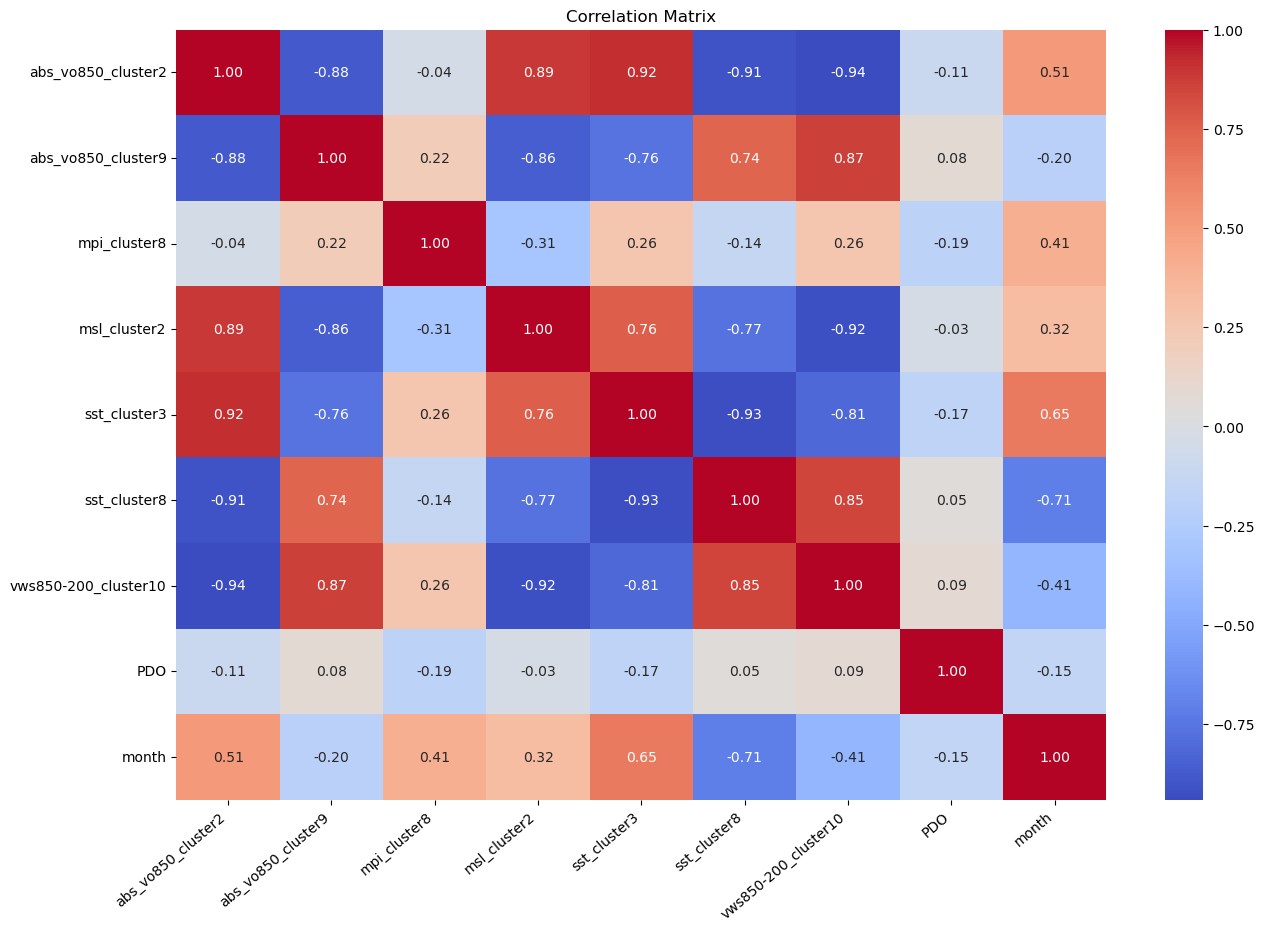

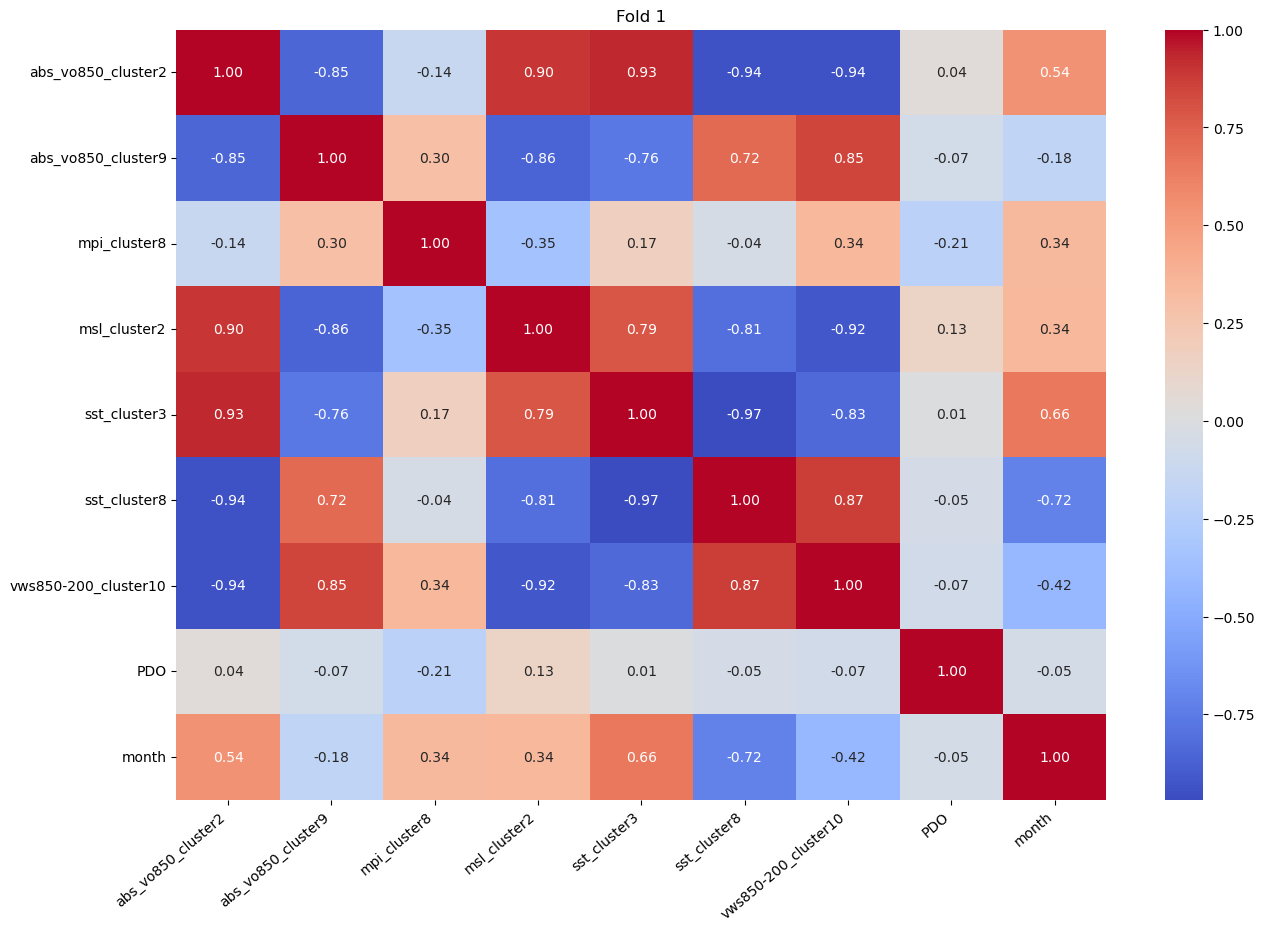

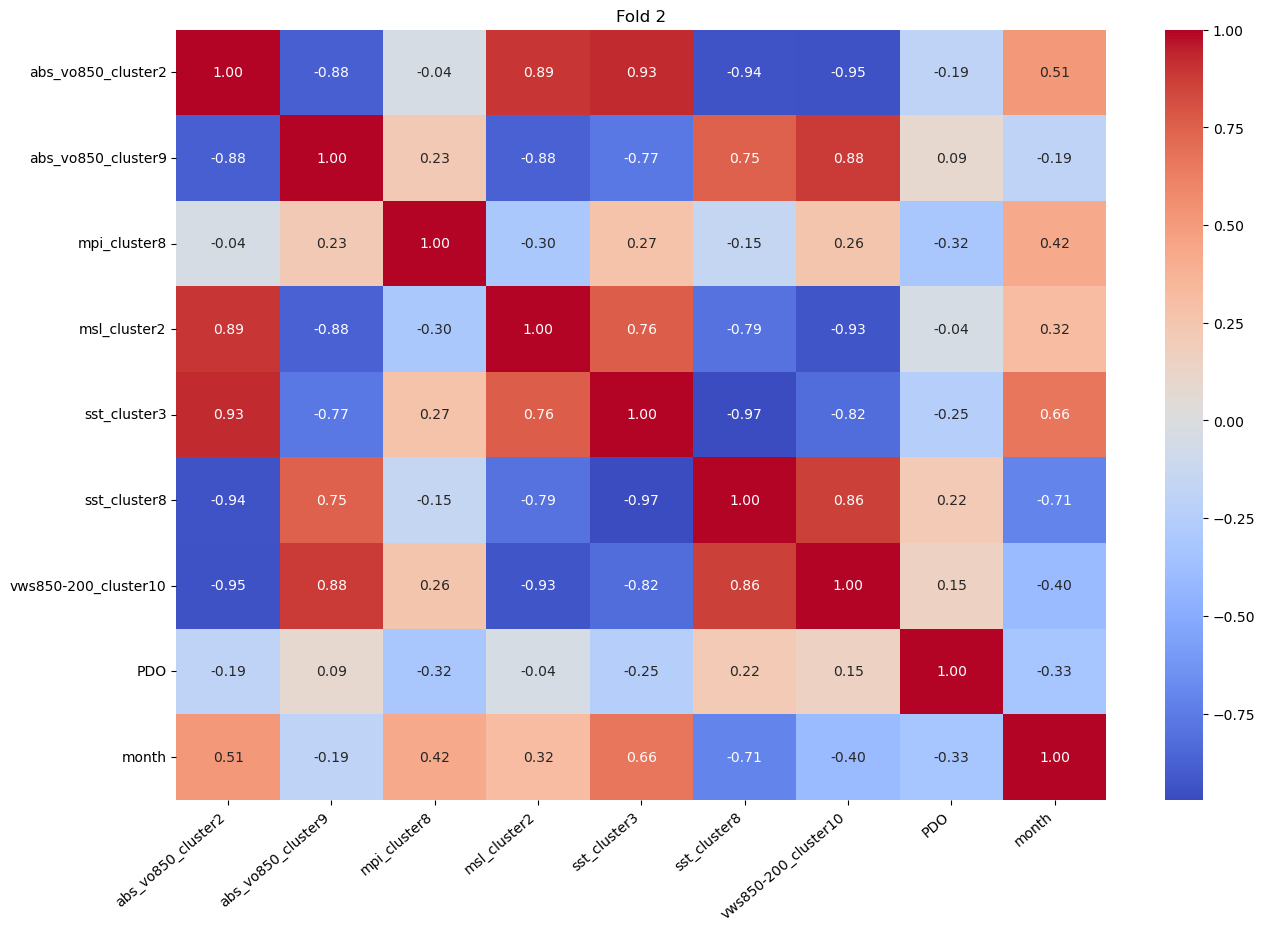

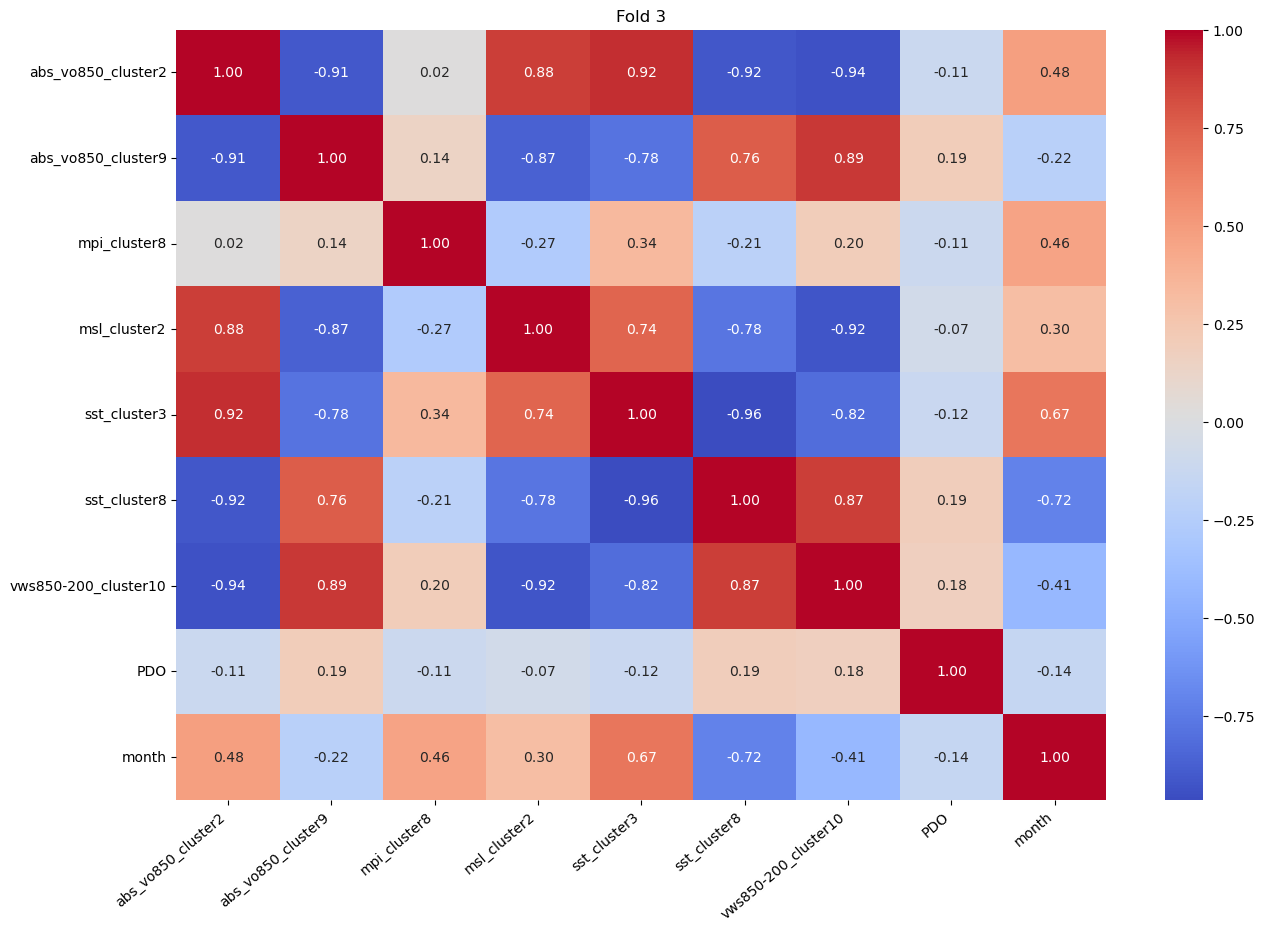

In [16]:
X_test = pd.concat([X_test_eval[0], X_test_eval[1], X_test_eval[2]], axis=0)
corr = X_test.corr()
fig = plt.figure(figsize=(15, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.xticks(rotation=40, ha='right')

for nf in range(3):
    corr = X_test_eval[nf].corr()
    fig = plt.figure(figsize=(15, 10))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f'Fold {nf+1}')
    plt.xticks(rotation=40, ha='right')

plt.show()

**Clusters selected**

In [17]:
# sel_clusters_dir = os.path.join(figures_dir, 'clusters_selected')
# sel_clusters_figs = os.listdir(sel_clusters_dir)
# for fig_name in sel_clusters_figs:
#     fig_path = os.path.join(sel_clusters_dir, fig_name)
#     fig = ut.load_pdf_convert_to_image(fig_path)
#     display(fig)